In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import welch
from scipy.fft import next_fast_len

import letalker as lt

# Python classes to model various `Element`s of Voice Production Mechanism

`pyLeTalker` package divides the voice production model into 5 distinctive elements: lungs, trachea (subglottal vocal tract), vocal folds (larynx), (supraglottal) vocal tract, and lips. Each element is implement as a concrete subclass of the `abc.Element` abstract class. A same wave reflection model can be used for both the trachea and vocal tract, thus there are 4 types of elements, which are represented by abstract subclasses of `abc.Element`:

| name                  | description                                                                                               |
|-----------------------|-----------------------------------------------------------------------------------------------------------|
| `abc.Lungs`           | Lungs / respiratory pressure generator, receiving incidental backward pressure, producing forward pressure |
| `abc.VocalTract`      | Tubes in which incidental pressure waves are propagating in both forward and backward directions          |
| `abc.VocalFolds`      | Larynx, injecting the oscillatory behavior to the propagating incidental pressures                        |
| `abc.Lips`            | Lip, transforming the incidental pressures to radiated sound pressure output                              |
| `abc.AspirationNoise` | Aspiration noise generator to be attached to `abc.VocalFolds`                                             |

The wave reflection model treats the voice production system as a chain of these elements, and at each connection the incidental pressure signals travels both forward and backward. The elements with full I/O (`abc.VocalTract` and `abc.VocalFolds`) have 4 ports while the terminating elements, both the source (`abc.Lungs`) and sink (`abc.Lips`), have 2 pressure ports exposed as illustrated below.

![Block Elements](../images/element_blocks.svg)

Each `Element` class has its own `Runner` and `Result` classes within and instantiated by the `Element` class. 

The `Runner` class is instantiated by `Element.create_runner()` method, which if needed converts set of user-friendly model parameters to an optimized parameterization for simulation. At each time step `n`, `Runner.step()` method of every element is executed to updates element's states given current input samples $F_{in,n}$ and $B_{in,n}$ and outputs $F_{out,n+1}$ and $B_{out,n+1}$. `Runner` objects also saves selected internal signals for later analysis. 

Once the simulation completes (i.e., calling the `Element.step()` of every element in a loop for the prescribed number of steps), the configurations and results are gathered fro each element as an `Element.Result` object via the `Element.create_result()` method.

### `abc.Lung` classes

There are 3 builtin lung classes:

| name           | description                                                                             |
| -------------- | --------------------------------------------------------------------------------------- |
| `LeTalkerLungs` | Propagates 90% of the respiratory pressure $P_{L,n}$ and reflects 80% of incidental backward wave $B_{in,n}$         |
| `OpenLungs`     | Outputs 100% of $P_{L,n}$ and 0% of $B_{in,n}$                                              |
| `NullLungs`     | No respiratory pressure and only reflects the incidental backward wave $B_{in,n}$ (80%) |


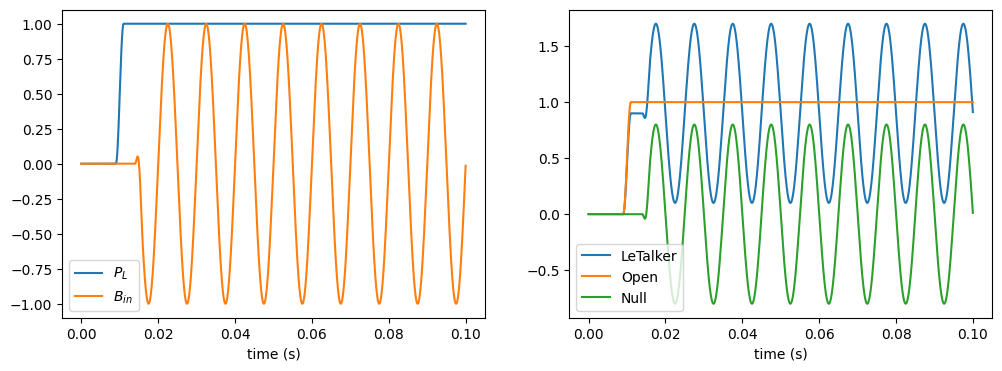

In [2]:
# create input signal generators
PL = lt.Constant(1.0, transition_time=0.01) # constant level at 1.0, starting at t=0.01 s
Bin_generator = lt.SineGenerator(100, transition_time=0.015) # 100 Hz sine wave starting at t=0.015 s
# create the base lung classes
lungs = {
    "LeTalker": lt.LeTalkerLungs(PL),
    "Open": lt.OpenLungs(PL),
    "Null": lt.NullLungs(),
}

# create their simulation runner objects
n = round(lt.constants.fs*0.1)  # number of samples to simulate
runners = [lung.create_runner(n) for lung in lungs.values()]

Bin = Bin_generator(n)  # backward pressure input
Fout = np.empty((n, len(runners)))  # forward pressure output
for i, b in enumerate(Bin):
    # Compute the next states of fsg & blung
    for j, runner in enumerate(runners):
        Fout[i, j] = runner.step(i, b)

t = Bin_generator.ts(n)
fig, axes = plt.subplots(1, 2, sharex=True, figsize=[12, 4])
axes[0].plot(t, PL(n), label="$P_L$")
axes[0].plot(t, Bin, label="$B_{in}$")
axes[0].legend()
axes[0].set_xlabel('time (s)')
axes[1].plot(t, Fout)
axes[1].legend(lungs,loc='lower left')
axes[1].set_xlabel('time (s)');

### `abc.Lip` class: `LeTalkerLips`

There is one builtin class, `LeTalkerLips`, which is an implementation of Ishizaka-Flanagan model, a circular piston in an infinite baffle.

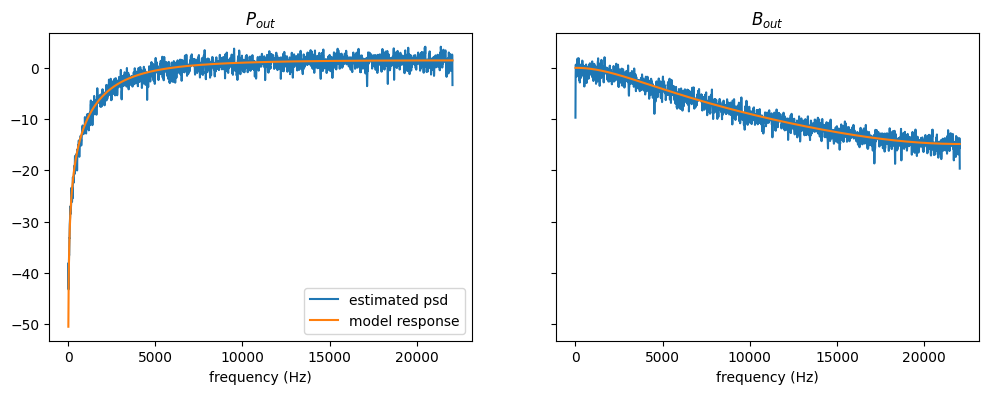

In [3]:
# create the lip class with time-varying lip crosssectional area
lips = lt.LeTalkerLips(upstream=3)

# create input signal generators (white noise)
Fin_generator = lt.WhiteNoiseGenerator()

# create their simulation runner objects
n = round(lips.fs)  # number of samples to simulate
runner = lips.create_runner(n)

Fin = Fin_generator(n)  # generate forward pressure input samples
Bout = np.empty(n)  # backward pressure output
for i, f in enumerate(Fin):
    # Compute the next states of bout
    Bout[i] = runner.step(i, f)

res = lips.create_result(runner)
t = res.ts

N = res.fs // 10
nfft = nfft = next_fast_len(lips.fs // 10)

f, H = next(lips.iter_freqz(n, forN=nfft // 2 + 1, include_nyquist=True))
Pp = welch(res.pout, nperseg=N, noverlap=N // 2, nfft=nfft)[1]  # / (lips.fs / 2)
Pb = welch(Bout, nperseg=N, noverlap=N // 2, nfft=nfft)[1]  # / (lips.fs / 2)

with np.errstate(divide='ignore'):
    HdB = 20 * np.log10(np.abs(H))
    PpdB = 10 * np.log10(Pp / 2)
    PbdB = 10 * np.log10(Pb / 2)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[12, 4])
axes[0].plot(f, PpdB, label="estimated psd")
axes[0].plot(f, HdB[0, :], label="model response")
axes[0].set_xlabel("frequency (Hz)")
axes[0].set_title("$P_{out}$")
axes[0].legend()

axes[1].plot(f, PbdB, label="estimated psd")
axes[1].plot(f, HdB[1, :], label="model response")
axes[1].set_xlabel("frequency (Hz)")
axes[1].set_title("$B_{out}$");

### `abc.VocalTract`

There are two builtin vocal tract models: `LeTalkerVocalTract` & `LossyCylinderVocalTract`. 

`pyLeTalker` uses the exact same vocal tract area data that were distributed in `LeTalker` Matlab program. They are 10 vowels (+1 modified version of `uu`) and another for a trachea, and they are found in the `lt.constants.vocaltract_areas` dict and its keys can also be found in:

In [4]:
print(f'{lt.constants.vocaltract_names=}')

lt.constants.vocaltract_names=('aa', 'ii', 'uu', 'ae', 'ih', 'eh', 'ah', 'aw', 'uh', 'oo', 'uumod', 'trach')


These keys for the vocal tract area can be specified as the `areas` argument of the `LeTalkerVocalTract` constructor.

The following code runs 4 different vocal tract models and plots the PSD estimates of the output pressure, driven by only one of the input pressure port. Note that these are open-loop behaviors and not the same as a simulation with lung and lip models attached to them (i.e., closed-loop simulation). Most notably, the `LossyCylinderVocalTract` model only attenuates and delays the signal. Only in a closed-loop configuration, this model will induce a resonance pattern.

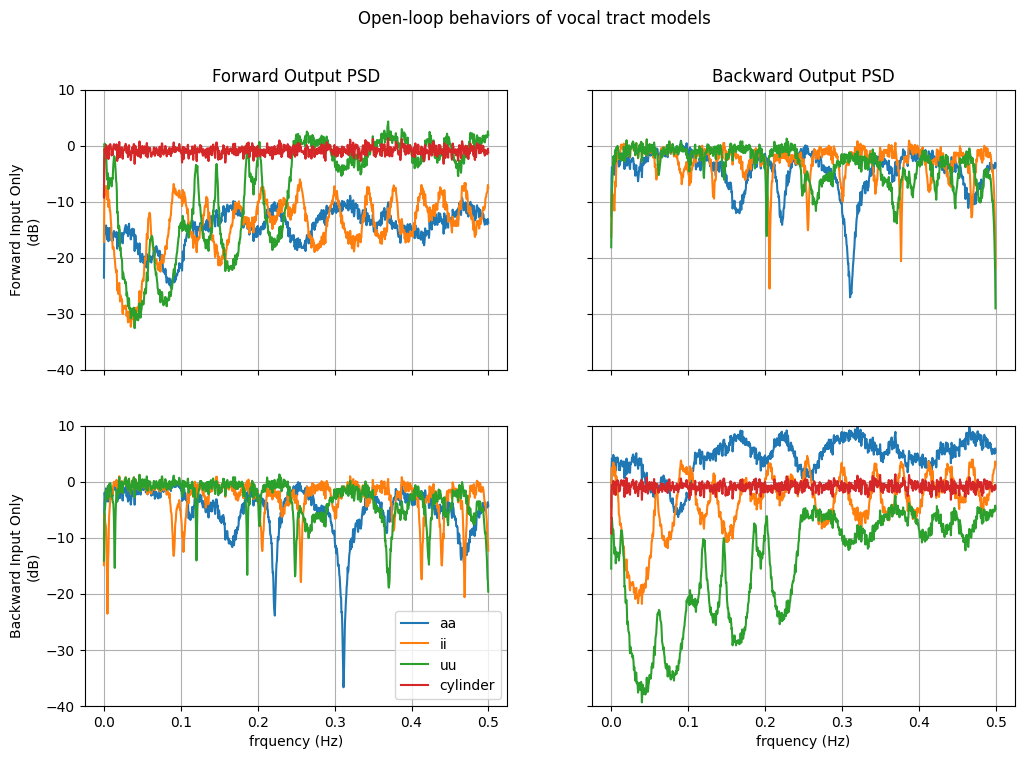

In [5]:
# create the lips class with time-varying lip crosssectional area
vt_models = {
    "aa": lt.LeTalkerVocalTract("aa", atten=lt.constants.vt_atten),
    "ii": lt.LeTalkerVocalTract("ii", atten=lt.constants.vt_atten),
    "uu": lt.LeTalkerVocalTract("uu", atten=lt.constants.vt_atten),
    "cylinder": lt.LossyCylinderVocalTract(
        44 * lt.constants.vocaltract_resolution, 5, atten=lt.constants.vt_atten
    ),
}
# - lt.constants.vt_atten = 0.002
n_models = len(vt_models)

# create input signal generators (white noise)
in_generator = lt.WhiteNoiseGenerator()

# create their simulation runner objects
n = round(lips.fs)  # number of samples to simulate
runners = [model.create_runner(n) for model in vt_models.values()]

# generate input samples and preallocate output arrays
x = in_generator(n)
y = np.zeros_like(x)
outputs = np.empty((n, n_models, 2, 2))  # pressure outputs

# run the simulation
for j, runner in enumerate(runners):  # for each model
    for k, inputs in enumerate([(x, y), (y, x)]):  # for each input
        for i, (f, b) in enumerate(zip(*inputs)):  # for each time sample
            outputs[i, j, k] = runner.step(i, f, b)
fs = lt.constants.fs
N = res.fs // 20
nfft = nfft = next_fast_len(N)

# PSD estimation
f, Pyy = welch(outputs, nperseg=N, noverlap=N // 2, nfft=nfft, axis=0)
with np.errstate(divide='ignore'):
    PyydB = 10 * np.log10(Pyy / 2)

# plot PSDs
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=[12, 8])
for i in range(2):  # input
    for j in range(2):  # output
        axes[i, j].plot(f, PyydB[:, :, i, j])
        axes[i, j].grid()
axes[0, 0].set_ylim(-40, 10)
fig.suptitle("Open-loop behaviors of vocal tract models")
axes[0, 0].set_title("Forward Output PSD")
axes[0, 1].set_title("Backward Output PSD")
axes[0, 0].set_ylabel("Forward Input Only\n(dB)")
axes[1, 0].set_ylabel("Backward Input Only\n(dB)")
axes[1, 0].set_xlabel("frquency (Hz)")
axes[1, 1].set_xlabel("frquency (Hz)")
axes[1, 0].legend(vt_models);

### `abc.VocalFolds` classes

There are 4 builtin vocal fold models in `pyLeTalker`:

| name                            | description                                         |
| ------------------------------- | --------------------------------------------------- |
| `VocalFoldsUg`                  | Known glottal flow (simulates no vocal fold motion) |
| `LeTalkerVocalFolds`            | Symmetric 3-mass model                              |
| `KinematicVocalFolds`           | Symmetric kinematic model                           |
| `AsymmetricKinematicVocalFolds` | Asymmetric kinematic model                          |


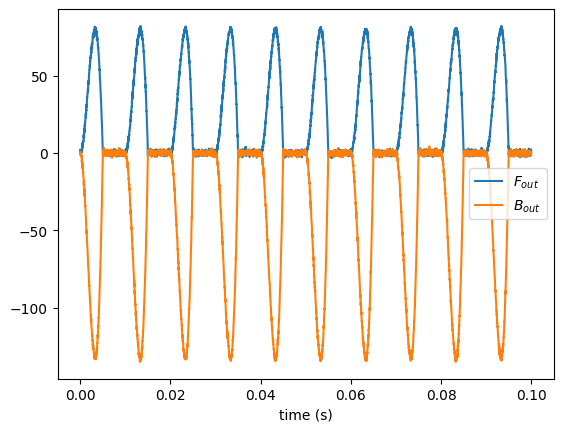

In [6]:
ug_gen = lt.RosenbergGenerator(100)
vf = lt.VocalFoldsUg(ug_gen, upstream=0.5, downstream=0.3) 
# set upstream and downstream tube cross-sectional areas

# create input signal generators (white noise)
Fin_generator = lt.WhiteNoiseGenerator()
Bin_generator = lt.WhiteNoiseGenerator()

# create their simulation runner objects
n = round(vf.fs // 10)  # number of samples to simulate
runner = vf.create_runner(n)

Fin = Fin_generator(n)  # generate forward pressure input samples
Bin = Bin_generator(n)  # generate forward pressure input samples
Bout = np.empty(n)  # backward pressure output
Fout = np.empty_like(Bout)
for i, (f, b) in enumerate(zip(Fin, Bin)):
    # Compute the next states of bout
    Fout[i], Bout[i] = runner.step(i, f, b)

res = vf.create_result(runner)
t = res.ts

plt.plot(t, Fout, label="$F_{out}$")
plt.plot(t, Bout, label="$B_{out}$")
plt.xlabel("time (s)")
plt.legend()

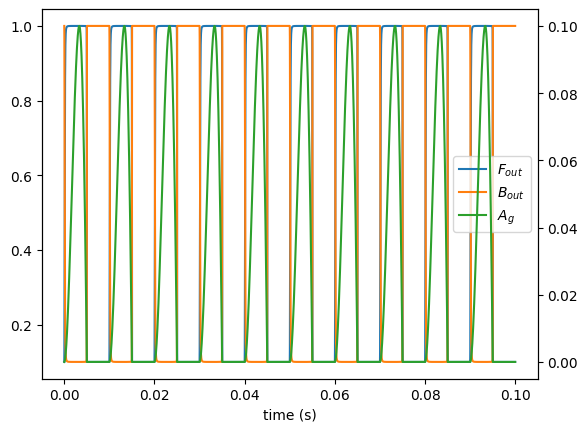

In [7]:
ag_gen = lt.RosenbergGenerator(100, 0.1)
vf = lt.VocalFoldsAg(ag_gen, upstream=1, downstream=1)

# create input signal generators (white noise)
Fin_generator = lt.Constant(1.0)
Bin_generator = lt.Constant(0.1)

# create their simulation runner objects
n = round(vf.fs // 10)  # number of samples to simulate
runner = vf.create_runner(n)

Fin = Fin_generator(n, force_time_axis='tile_data')  # generate forward pressure input samples
Bin = Bin_generator(n, force_time_axis='tile_data')  # generate forward pressure input samples
Bout = np.empty(n)  # backward pressure output
Fout = np.empty_like(Bout)
for i, (f, b) in enumerate(zip(Fin, Bin)):
    # Compute the next states of bout
    Fout[i], Bout[i] = runner.step(i, f, b)

res = vf.create_result(runner)
t = res.ts

plt.plot(t, Fout, label="$F_{out}$")
plt.plot(t, Bout, label="$B_{out}$")
plt.plot([], [], label="$A_{g}$")
plt.legend()
plt.xlabel("time (s)")
plt.twinx()
plt.plot(t, ag_gen(n), c="C2")

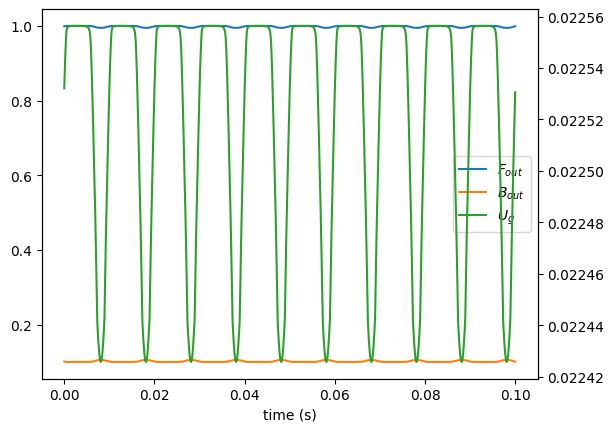

In [8]:
vf = lt.KinematicVocalFolds(100, **lt.constants.male_vf_params, upstream=1,downstream=1)

# create input signal generators (white noise)
Fin_generator = lt.Constant(1.0)
Bin_generator = lt.Constant(0.1)

# create their simulation runner objects
n = round(vf.fs // 10)  # number of samples to simulate
runner = vf.create_runner(n)

Fin = Fin_generator(n, force_time_axis='tile_data')  # generate forward pressure input samples
Bin = Bin_generator(n, force_time_axis='tile_data')  # generate forward pressure input samples
Bout = np.empty(n)  # backward pressure output
Fout = np.empty_like(Bout)
for i, (f, b) in enumerate(zip(Fin, Bin)):
    # Compute the next states of bout
    Fout[i], Bout[i] = runner.step(i, f, b)

res = vf.create_result(runner)
t = res.ts

plt.plot(t, Fout, label="$F_{out}$")
plt.plot(t, Bout, label="$B_{out}$")
plt.plot([], [], label="$U_{g}$")
plt.legend()
plt.xlabel("time (s)")
plt.twinx()
plt.plot(t, res.ug, c="C2");

#### `KinematicVocalFolds` - Symmetric and Asymmetric Kinematic Vocal Folds

`KinematicVocalFolds` is a subclass of `VocalFoldsAg` and generates the glottal area waveform from prescribed vocal fold geometry and motion equations.

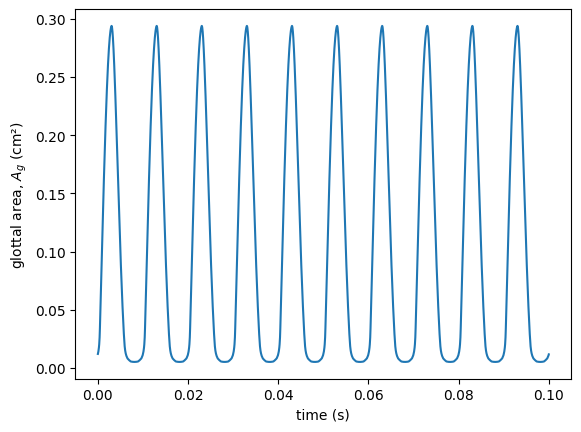

In [9]:
vf = lt.KinematicVocalFolds(100) # default (male) model with fo = 100 Hz

plt.plot(vf.ts(n),vf.glottal_area(n))
plt.xlabel('time (s)')
plt.ylabel('glottal area, $A_g$ (cm²)');

`KinematicVocalFolds` can also support left-right asymmetry of any of its parameters

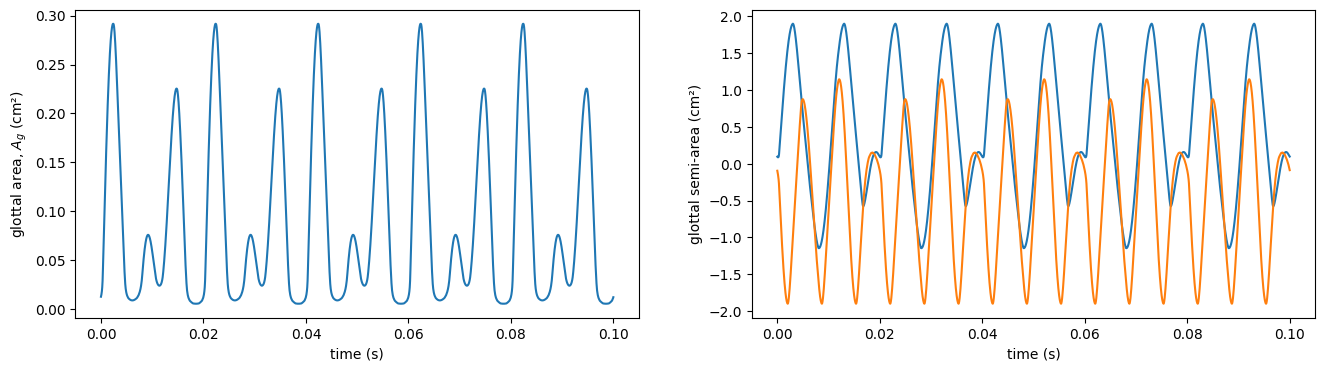

In [10]:
# 2:3 entrained biphonic phonation of the default (male) model with fo = 100 Hz and 150 Hz
vf = lt.KinematicVocalFolds([100, 150])

fig, axes = plt.subplots(1, 2, sharex=True, figsize=[16, 4])

axes[0].plot(vf.ts(n), vf.glottal_area(n).T)
axes[0].set_xlabel("time (s)")
axes[0].set_ylabel("glottal area, $A_g$ (cm²)")

x_semi = vf.xi(n).min(-1).sum(-1)
# axes[1].plot(vf.ts(n), x_semi.T)
axes[1].plot(vf.ts(n), x_semi[0], vf.ts(n), -x_semi[1])
axes[1].set_xlabel("time (s)")
axes[1].set_ylabel("glottal semi-area (cm²)");

#### `LeTalkerVocalFolds`: symmetric (linearized) 3-mass model with muscle activation controls

Text(0.5, 0, 'time (ms)')

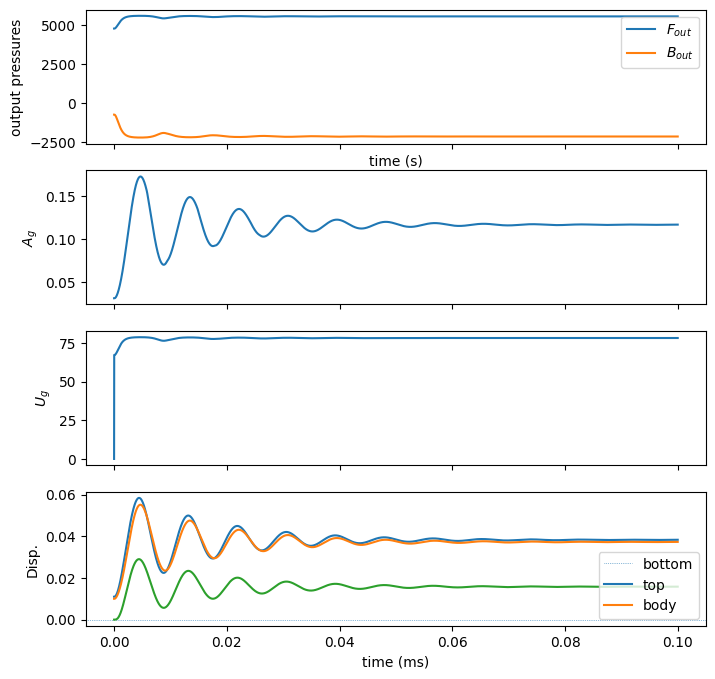

In [11]:
vf = lt.LeTalkerVocalFolds(
    upstream=lt.constants.vocaltract_areas["trach"][-1],
    downstream=lt.constants.vocaltract_areas["aa"][0],
)

# create input signal generators (white noise)
Fin_generator = lt.Constant(lt.constants.PL)
Bin_generator = lt.Constant(0.0)

# create their simulation runner objects
n = round(vf.fs // 10)  # number of samples to simulate
runner = vf.create_runner(n)

Fin = Fin_generator(n, force_time_axis='tile_data')  # generate forward pressure input samples
Bin = Bin_generator(n, force_time_axis='tile_data')  # generate forward pressure input samples
Bout = np.empty(n)  # backward pressure output
Fout = np.empty_like(Bout)
for i, (f, b) in enumerate(zip(Fin, Bin)):
    # Compute the next states of bout
    Fout[i], Bout[i] = runner.step(i, f, b)

res = vf.create_result(runner)
t = res.ts

fig, axes = plt.subplots(4, 1, sharex=True, figsize=[8, 8])
axes[0].plot(t, Fout, label="$F_{out}$")
axes[0].plot(t, Bout, label="$B_{out}$")
axes[0].set_ylabel("output pressures")
axes[0].set_xlabel("time (s)")
axes[0].legend()
axes[1].plot(t, res.ag[:-1])
axes[1].set_ylabel("$A_g$")
axes[2].plot(t, res.ug[:-1])
axes[2].set_ylabel("$U_g$")
axes[3].axhline(0, ls=":", lw=0.5)
axes[3].plot(t, res.displacements)
axes[3].legend(["bottom", "top", "body"])
axes[3].set_ylabel("Disp.")
axes[3].set_xlabel("time (ms)")

# fig.align_ylabels(axes)

## `abc.AspirationNoise` - Aspiration noise (turbulent noise injected at the glottis-epiglottal junction)

There are two builtin concrete classes:

| name                      | description                                                             |
|---------------------------|-------------------------------------------------------------------------|
| `LeTalkerAspirationNoise` | Bandlimited noise injected only if Reynold number is above the thresold |
| `KlattAspirationNoise`    | Bandlimited noise injected at two levels depending on Reynold number    |

Both of these models can be customized with different white noise generator (Gaussian, uniform, etc.) and spectral shaping filter.

Text(0.5, 0, 'time (s)')

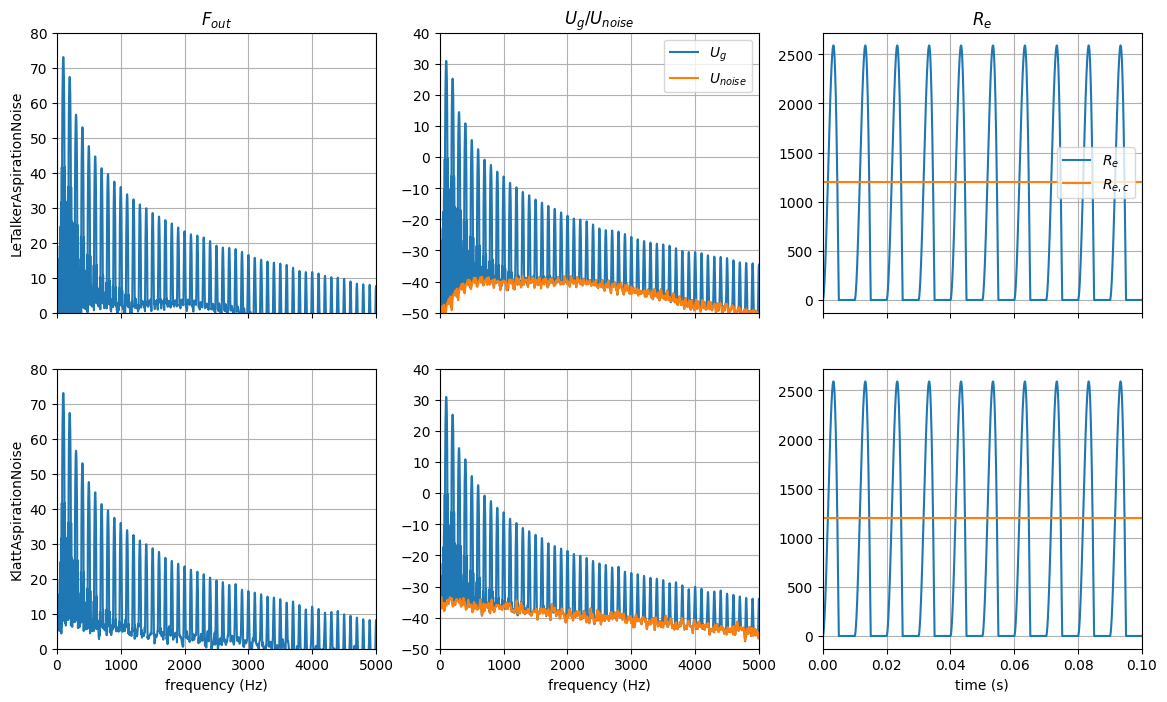

In [12]:
# create aspiration noise sources
lt_noise = lt.LeTalkerAspirationNoise()
kl_noise = lt.KlattAspirationNoise()

# create kinematic vocal fold models at fo=100Hz and assign the noise objects to them
kwargs = {
    "upstream": lt.constants.vocaltract_areas["trach"][-1],
    "downstream": lt.constants.vocaltract_areas["aa"][0],
    "length": lt.constants.male_vf_params["L0"],
}

ug_gen = lt.RosenbergGenerator(100, 600)

vf_lt = lt.VocalFoldsUg(ug_gen, aspiration_noise=lt_noise, **kwargs)
vf_kl = lt.VocalFoldsUg(ug_gen, aspiration_noise=kl_noise, **kwargs)

# create their simulation runner objects
n = round(vf_lt.fs)  # number of samples to simulate
lt_runner = vf_lt.create_runner(n)
kl_runner = vf_kl.create_runner(n)

# preallocate forward pressure output array (ignore backward outputs for now)
Fout = np.empty((n, 2))

# run simulation
b = [0, 0]
for i in range(n):
    Fout[i, 0], _ = lt_runner.step(i, 0.0, 0.0)
    Fout[i, 1], _ = kl_runner.step(i, 0.0, 0.0)

# gather the results
lt_res = vf_lt.create_result(lt_runner)
kl_res = vf_kl.create_result(kl_runner)
t = lt_res.ts

fs = lt.constants.fs
N = round(lt_res.fs * 0.1)
nfft = nfft = next_fast_len(fs)

# PSD estimation
f, Pxx = welch(
    [lt_res.ug, kl_res.ug], nperseg=N, noverlap=N // 2, nfft=nfft, axis=-1, fs=fs
)
_, Pyy = welch(Fout, nperseg=N, noverlap=N // 2, nfft=nfft, axis=0, fs=fs)
_, Pzz = welch(
    [lt_res.aspiration_noise.unoise, kl_res.aspiration_noise.unoise],
    nperseg=N,
    noverlap=N // 2,
    nfft=nfft,
    axis=-1,
    fs=fs,
)
PyydB = 10 * np.log10(Pyy / 2)

# plot PSDs
fig, axes = plt.subplots(2, 3, figsize=[14, 8], sharex="col", sharey="col")
axes[0, 0].plot(f, PyydB[:, 0])
axes[0, 0].grid()
axes[0, 0].set_xlim((0, 5000))
axes[0, 0].set_ylim((0, 80))
axes[0, 0].set_title("$F_{out}$")
axes[0, 0].set_ylabel("LeTalkerAspirationNoise")
axes[1, 0].plot(f, PyydB[:, 1])
axes[1, 0].grid()
axes[1, 0].set_xlabel("frequency (Hz)")
axes[1, 0].set_ylabel("KlattAspirationNoise")

axes[0, 1].plot(f, 10 * np.log10(Pxx[0, :] / 2), label="$U_g$")
axes[0, 1].plot(f, 10 * np.log10(Pzz[0, :] / 2), label="$U_{noise}$")
axes[0, 1].grid()
axes[0, 1].legend()
axes[0, 1].set_xlim((0, 5000))
axes[0, 1].set_ylim((-50, 40))
axes[0, 1].set_title("$U_g$/$U_{noise}$")
axes[1, 1].plot(f, 10 * np.log10(Pxx[1, :] / 2), label="$U_g$")
axes[1, 1].plot(f, 10 * np.log10(Pzz[1, :] / 2), label="$U_{noise}$")
axes[1, 1].grid()
axes[1, 1].set_xlabel("frequency (Hz)")

axes[0, 2].plot(t, lt_res.aspiration_noise.re2**0.5, label="$R_e$")
axes[0, 2].axhline(lt_res.aspiration_noise.re2b**0.5, c="C1", label="$R_{e,c}$")
axes[0, 2].grid()
axes[0, 2].set_title("$R_e$")
axes[0, 2].legend()
axes[1, 2].plot(t, kl_res.aspiration_noise.re2**0.5, label="$R_e$")
axes[1, 2].axhline(kl_res.aspiration_noise.re2b**0.5, c="C1", label="$R_{e,c}$")
axes[1, 2].grid()
axes[1, 2].set_xlim((0, 0.1))
axes[1, 2].set_xlabel("time (s)")
